# Setup

In [31]:
import logging
import math

import torch
import torch.nn.functional as F
from torch import nn

#
# From StableDynamics.ipynb; Zico Kolter
#

# You can use this to compensate for numeric error:
VERIFY = False
V_SCALE = 0.01

global V_WRAP, SCALE_FX
V_WRAP = False
SCALE_FX = False

class Dynamics(nn.Module):
    def __init__(self, fhat, V, alpha=0.01):
        super().__init__()
        self.fhat = fhat
        self.V = V
        self.alpha = 0 # alpha

    def forward(self, x):
        fx = self.fhat(x)
        if SCALE_FX:
            fx = fx / fx.norm(p=2, dim=1, keepdim=True).clamp(min=1.0)

        Vx = self.V(x)
        gV = torch.autograd.grad([a for a in Vx], [x], create_graph=True, only_inputs=True)[0]
        rv = fx - gV * (F.relu((gV*fx).sum(dim=1) + self.alpha*Vx[:,0])/(gV**2).sum(dim=1))[:,None]

        if VERIFY:
            # Verify that rv has no positive component along gV.
            # This helps us catch:
            #   (1) numeric error in the symbolic gradient calculation, and
            #   (2) Violation of the Lyapunov function when Euler integration is used.
            verify = (gV * rv).sum(dim=1)
            num_violation = len([v for v in verify if v > 0]) # (1)
            new_V = self.V(x + V_SCALE * rv)
            if (new_V > Vx).any(): # (2)
                err = sorted([v for v in (new_V - Vx).detach().cpu().numpy().ravel() if v > 0], reverse=True)

        return rv

class ICNN(nn.Module):
    def __init__(self, layer_sizes, activation=F.relu_):
        super().__init__()
        self.W = nn.ParameterList([nn.Parameter(torch.Tensor(l, layer_sizes[0])) 
                                   for l in layer_sizes[1:]])
        self.U = nn.ParameterList([nn.Parameter(torch.Tensor(layer_sizes[i+1], layer_sizes[i]))
                                   for i in range(1,len(layer_sizes)-1)])
        self.bias = nn.ParameterList([nn.Parameter(torch.Tensor(l)) for l in layer_sizes[1:]])
        self.act = activation
        self.reset_parameters()

    def reset_parameters(self):
        # copying from PyTorch Linear
        for W in self.W:
            nn.init.kaiming_uniform_(W, a=5**0.5)
        for U in self.U:
            nn.init.kaiming_uniform_(U, a=5**0.5)
        for i,b in enumerate(self.bias):
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W[i])
            bound = 1 / (fan_in**0.5)
            nn.init.uniform_(b, -bound, bound)

    def forward(self, x):
        z = F.linear(x, self.W[0], self.bias[0])
        z = self.act(z)

        for W,b,U in zip(self.W[1:-1], self.bias[1:-1], self.U[:-1]):
            z = F.linear(x, W, b) + F.linear(z, F.softplus(U)) / U.shape[0]
            z = self.act(z)

        return F.linear(x, self.W[-1], self.bias[-1]) + F.linear(z, F.softplus(self.U[-1])) / self.U[-1].shape[0]



class ReHU(nn.Module):
    """ Rectified Huber unit"""
    def __init__(self, d):
        super().__init__()
        self.a = 1/d
        self.b = -d/2

    def forward(self, x):
        return torch.max(torch.clamp(torch.sign(x)*self.a/2*x**2,min=0,max=-self.b),x+self.b)

class MakePSD(nn.Module):
    def __init__(self, f, n, eps=0.01, d=1.0):
        super().__init__()
        self.f = f
        self.zero = torch.nn.Parameter(f(torch.zeros(1,n)), requires_grad=False)
        self.eps = eps
        self.d = d
        self.rehu = ReHU(self.d)

    def forward(self, x):
        smoothed_output = self.rehu(self.f(x) - self.zero)
        quadratic_under = self.eps*(x**2).sum(1,keepdim=True)
        return smoothed_output + quadratic_under

class PosDefICNN(nn.Module):
    def __init__(self, layer_sizes, eps=0.1, negative_slope=0.05):
        super().__init__()
        self.W = nn.ParameterList([nn.Parameter(torch.Tensor(l, layer_sizes[0])) 
                                   for l in layer_sizes[1:]])
        self.U = nn.ParameterList([nn.Parameter(torch.Tensor(layer_sizes[i+1], layer_sizes[i]))
                                   for i in range(1,len(layer_sizes)-1)])
        self.eps = eps
        self.negative_slope = negative_slope
        self.reset_parameters()

    def reset_parameters(self):
        # copying from PyTorch Linear
        for W in self.W:
            nn.init.kaiming_uniform_(W, a=5**0.5)
        for U in self.U:
            nn.init.kaiming_uniform_(U, a=5**0.5)

    def forward(self, x):
        z = F.linear(x, self.W[0])
        F.leaky_relu_(z, negative_slope=self.negative_slope)

        for W,U in zip(self.W[1:-1], self.U[:-1]):
            z = F.linear(x, W) + F.linear(z, F.softplus(U))*self.negative_slope
            z = F.leaky_relu_(z, negative_slope=self.negative_slope)

        z = F.linear(x, self.W[-1]) + F.linear(z, F.softplus(self.U[-1]))
        return F.relu(z) + self.eps*(x**2).sum(1)[:,None]

def loss(Ypred, Yactual, X):
    # Force smoothness in V:
    # penalty for new_V being larget than old V:
    Vloss = torch.tensor(0)
    if SMOOTH_V:
        V = model.V
        # Successor to X:
        succ_X = (X + V_SCALE * Yactual).detach()
        if V_WRAP:
            while torch.any(succ_X < -math.pi):
                succ_X[succ_X < -math.pi] = succ_X[succ_X < -math.pi] + 2 * math.pi
            while torch.any(succ_X >= math.pi):
                succ_X[succ_X >= math.pi] = succ_X[succ_X >= math.pi] - 2 * math.pi
            succ_X.requires_grad_()

        Vloss = (V(succ_X) - V(X)).clamp(min=0).mean()

    l2loss = ((Ypred - Yactual)**2).mean()

    return (l2loss + SMOOTH_V * Vloss, l2loss, Vloss)

global model, SMOOTH_V
model = None
SMOOTH_V = 0

def loss_flatten(l):
    return l

def loss_labels():
    return ["loss", "l2", "V"]

def summary(*a, **kw):
    pass

# Verification

In [32]:
lsd = 2
ph_dim = 32
h_dim = 32

fhat = nn.Sequential(nn.Linear(lsd, h_dim), nn.ReLU(),
                        nn.Linear(h_dim, h_dim), nn.ReLU(),
                        nn.Linear(h_dim, lsd))

rehu = 0.005
projfn_eps = 0.01


V = nn.Sequential(
        nn.Linear(lsd, ph_dim,), nn.ReLU(),
        nn.Linear(ph_dim, ph_dim), nn.ReLU(),
        nn.Linear(ph_dim, 1))
model = Dynamics(fhat, V, alpha=0)

In [33]:
# print(V.f.W[0])

In [34]:
model.load_state_dict(torch.load("standard_5k.pth"))
model.eval()

Dynamics(
  (fhat): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
  (V): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

# Load trajectory

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from scipy.integrate import odeint


FILE = "p-physics-1.npy"
N = 1

data = np.load(FILE)
print(f"Loaded data: {data.shape}")
selected_data = data[:,1,:]

load = np.load("p-1-train.npz")
selected_data = load["X"]

Loaded data: (1000, 100, 2)


In [36]:
evals = []

x_plot = []
y_plot = []
for i in range(len(selected_data)):
    input = torch.FloatTensor([selected_data[i]])
    input.requires_grad = True
    x_plot.append(input[0][0].item())
    y_plot.append(input[0][1].item())
    energy_val = V(input).detach().item()
    evals.append(energy_val)

evals

[-0.2358492910861969,
 -0.40249714255332947,
 -0.6902679800987244,
 -0.3114587068557739,
 -0.4607688784599304,
 -0.37579256296157837,
 -0.6222784519195557,
 -0.6552721858024597,
 -0.7535740733146667,
 -0.34696319699287415,
 -0.550661563873291,
 -0.8285416960716248,
 -0.46078482270240784,
 -0.8805213570594788,
 -0.8444634079933167,
 -0.4458464980125427,
 -0.272255003452301,
 -0.3732336163520813,
 -0.509590744972229,
 -0.2306147813796997,
 -0.2520681917667389,
 -0.3415944576263428,
 -0.27840209007263184,
 -0.519978404045105,
 -0.595099687576294,
 -0.5325351357460022,
 -0.37925687432289124,
 -0.7365733981132507,
 -0.8650175929069519,
 -0.31606659293174744,
 -0.6865052580833435,
 -0.29590556025505066,
 -0.27874353528022766,
 -0.5362700819969177,
 -0.23446765542030334,
 -0.4380410313606262,
 -0.7817701697349548,
 -0.5052292943000793,
 -0.2845269739627838,
 -0.8104608058929443,
 -0.6675263047218323,
 -0.28223952651023865,
 -0.3051917552947998,
 -0.3214907646179199,
 -0.3883986175060272,
 -0.

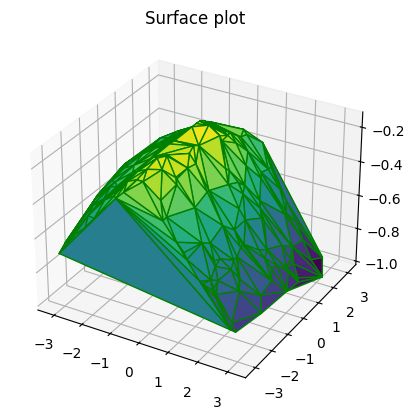

In [37]:
from matplotlib import pyplot as plt
fig = plt.figure()
 
# syntax for 3-D plotting
ax = plt.axes(projection='3d')
 
# syntax for plotting
ax.plot_trisurf(x_plot, y_plot, evals, cmap='viridis',\
                edgecolor='green')
ax.set_title('Surface plot')
plt.show()

In [38]:
import plotly.graph_objects as go
import numpy as np

# Assuming your x_plot, y_plot, and evals are lists of 199 elements each
x_plot = np.array(x_plot)
y_plot = np.array(y_plot)
evals = np.array(evals)

fig = go.Figure(
    data=[go.Scatter3d(x=x_plot, y=y_plot, z=evals, mode='markers')]
)
fig.update_layout(
    title='V(x) outputs against a small training set (ICNN)',
    autosize=False,
    width=500,
    height=500,
    margin=dict(l=65, r=50, b=65, t=90),
    scene_aspectmode='cube'
)
fig.show()


In [39]:
len(evals)

200

In [40]:
load = np.load("p-1-train.npz")
X = load["X"]
np.shape(X)

(200, 2)